In [1]:
# import torch
# from PIL import Image
# from torchvision import transforms
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
# model.eval()

In [3]:
import torch
from PIL import Image
from torchvision import transforms
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg11', pretrained=True)

# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg13_bn', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19_bn', pretrained=True)
model.eval()

Using cache found in /home/chiayungjui0/.cache/torch/hub/pytorch_vision_v0.9.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/chiayungjui0/.cache/torch/hub/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

13.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

23.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Helper for hook some specific layer.
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt      # plot library.
from IPython.display import display 
%matplotlib inline

# TARGET_LAYER = 'fc'
TARGET_LAYER = 'avgpool'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

if torch.cuda.is_available():
    model.to('cuda')

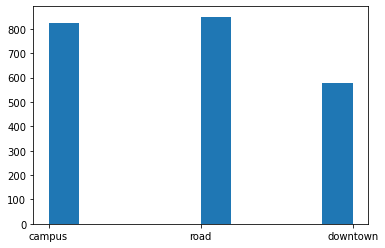

In [7]:
def scene_tag(file_name):
    set_tag = file_name.split('_')[0][-2:]
    if set_tag == "06" or set_tag == "09":
        return 'campus'
    if set_tag == "07" or set_tag == "10":
        return 'road'
    if set_tag == "08" or set_tag == "11":
        return 'downtown'

# Dealing with the filename first.
BASE_DIR = 'kaist_test/kaist_test_visible'
file_names = [f for f in os.listdir(BASE_DIR) if '.png' in f]
scene_tags = [scene_tag(f) for f in file_names]

plt.hist(scene_tags);

In [8]:
%%time 
imgs = [Image.open(os.path.join(BASE_DIR, fn)) for fn in file_names]
imgs = [preprocess(img).unsqueeze(0) for img in imgs]

CPU times: user 1min 53s, sys: 1.72 s, total: 1min 54s
Wall time: 1min 3s


In [139]:
%%time
outputs = []
batch_sz = 32
n_batch = len(imgs)//batch_sz
res_batch = len(imgs)%batch_sz

if TARGET_LAYER == 'avgpool':
    model.avgpool.register_forward_hook(get_activation('avgpool'))
    
if TARGET_LAYER == 'fc':
    model.fc.register_forward_hook(get_activation('fc'))

with torch.no_grad():

    for i in range(n_batch):
        in_batch = torch.cat(imgs[i*batch_sz:(i+1)*batch_sz]).to('cuda')

        output = model(in_batch)
#         outputs.append(output)
        outputs.append(activation[TARGET_LAYER])

    in_batch = torch.cat(imgs[-res_batch:]).to('cuda')
    in_batch.to('cuda')
    output = model(in_batch)
#     outputs.append(output)
    outputs.append(activation[TARGET_LAYER])

outputs = torch.cat(outputs)
X = outputs.to('cpu')
    
print("Output shape: {:}".format(outputs.shape))

Output shape: torch.Size([2252, 2048, 1, 1])
CPU times: user 6.33 s, sys: 801 ms, total: 7.13 s
Wall time: 3.72 s


In [140]:
X.shape

torch.Size([2252, 2048, 1, 1])

In [141]:
# Save the latent vector.

# np.save("latent_{:}-out.npy".format(outputs.shape[1]), X)

In [142]:
# TSNE?

In [143]:
%%time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X_embedded = TSNE(n_components=2).fit_transform(X[:,:,0,0])

# X_embedded = TSNE(n_components=2, perplexity=30.0,
#                 early_exaggeration=30.0,
#                 learning_rate=200.0,
#                 n_iter=1000,
#                 n_iter_without_progress=500,).fit_transform(X)

CPU times: user 23.9 s, sys: 342 ms, total: 24.2 s
Wall time: 6.15 s


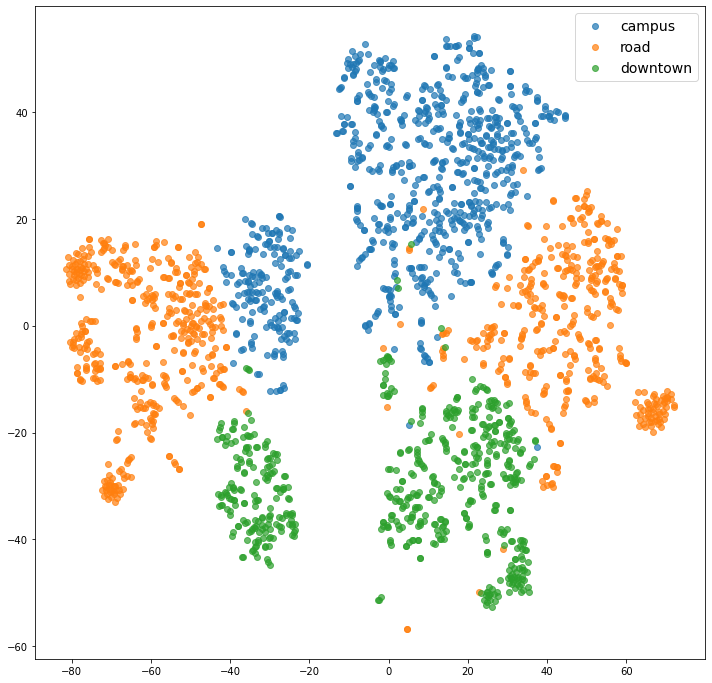

In [144]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12));

for idx, tag in enumerate(['campus', 'road', 'downtown']):
    mask = np.asarray(scene_tags) == tag
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=tag, alpha=0.7)
    
plt.legend(fontsize=14);

In [30]:
%%time
# from sklearn.decomposition import PCA.
X_embedded_3d = TSNE(n_components=3).fit_transform(X)

CPU times: user 1min 35s, sys: 246 ms, total: 1min 35s
Wall time: 24 s


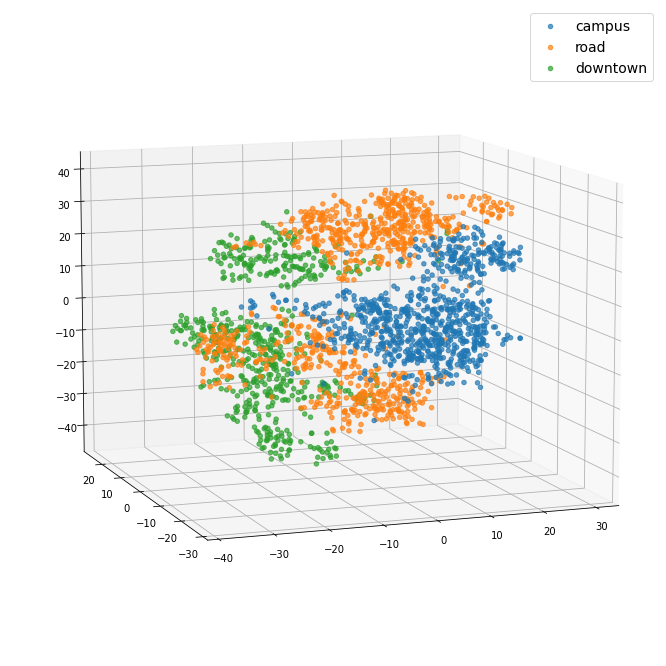

In [31]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

# X_embedded_3d = TSNE(n_components=3).fit_transform(X[:,:,0,0])

angle = -110
ax.view_init(10, angle)

for idx, tag in enumerate(['campus', 'road', 'downtown']):
    mask = np.asarray(scene_tags) == tag
    
    ax.scatter3D(X_embedded_3d[mask, 0], X_embedded_3d[mask, 1], X_embedded_3d[mask, 2], label=tag, alpha=0.7)
    
plt.legend(fontsize=14);

In [ ]:
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3).fit_transform(X[])

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

for idx, tag in enumerate(['campus', 'road', 'downtown']):
    mask = np.asarray(scene_tags) == tag
    
    ax.scatter3D(pca_3d[mask, 0], pca_3d[mask, 1], pca_3d[mask, 2], label=tag, alpha=0.7)
    
plt.legend(fontsize=14);

In [ ]:
print("This is good")